# Introduction

Cover My Meds Corporate

Library imports & required packages

In [25]:
!pip install -q prophet
!pip install -q pycaret==3.0.0.rc2

from prophet import Prophet
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
import numpy as np
from pycaret.time_series import *
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

     |████████████████████████████████| 538 kB 5.1 MB/s 
     |████████████████████████████████| 72 kB 780 kB/s 
     |████████████████████████████████| 141 kB 53.3 MB/s 
     |████████████████████████████████| 1.9 MB 49.0 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 15.9 MB 2.8 MB/s 
     |████████████████████████████████| 2.0 MB 44.6 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 79.9 MB 108 kB/s 
     |████████████████████████████████| 106 kB 49.3 MB/s 
     |████████████████████████████████| 9.4 MB 42.7 MB/s 
     |████████████████████████████████| 3.4 MB 36.1 MB/s 
     |████████████████████████████████| 280 kB 67.3 MB/s 
     |████████████████████████████████| 1.6 MB 49.6 MB/s 
     |████████████████████████████████| 295 kB 40.5 MB/s 
     |████████████████████████████████| 965 kB 53.0 MB/s 
     |████████████████████████████████| 34.5 MB 11 kB/s 
     |████████████████

INFO:logs:Sof dependency imported: prophet: 1.1.1


# Data Loading & Preprocessing

In [66]:
import pandas as pd

claims_df = pd.read_csv('/dim_claims.csv')
#print(claims_df.head())

data_df = pd.read_csv('/dim_date.csv')
#print(data_df.head())

pa_df = pd.read_csv('/dim_pa.csv')
#print(pa_df.head())

bridge_df = pd.read_csv('/bridge.csv')
#print(bridge_df.head())


Merging data via bridge table into a single DataFrame

In [67]:
bridge_date_merged_df = pd.merge(data_df, bridge_df, on='dim_date_id')
claims_date_bridge_merged = pd.merge(bridge_date_merged_df, claims_df, on='dim_claim_id')
claims_date_bridge__pa_merged = pd.merge(claims_date_bridge_merged[pd.notnull(claims_date_bridge_merged.dim_pa_id)], pa_df, on='dim_pa_id', how='inner')

Setting up a DateTime index for time series analysis at the daily and monthly level

In [68]:
data = claims_date_bridge__pa_merged[claims_date_bridge__pa_merged['pharmacy_claim_approved'] == 0]
data = data.rename(columns={'date_val' : 'datetime'})
data['pa_claim_made'] = 1
data['datetime'] = (pd.to_datetime(data['datetime']))
data = data.drop(columns=['calendar_day', 'day_of_week', 'dim_date_id', 'dim_claim_id', 'dim_pa_id','bin', 'drug', 'reject_code', 'pharmacy_claim_approved', 'calendar_year', 'calendar_month'])
data = data.set_index('datetime')
data.tail()

,is_weekday,is_workday,is_holiday,correct_diagnosis,tried_and_failed,contraindication,pa_approved,pa_claim_made
datetime,,,,,,,,
2019-12-31,1,1,0,1,0,1,0,1
2019-12-31,1,1,0,1,0,1,1,1
2019-12-31,1,1,0,1,1,1,1,1
2019-12-31,1,1,0,1,0,0,1,1
2019-12-31,1,1,0,0,0,1,0,1


Obtain daily time series data and monthly time series data

In [69]:
daily_data_ts = data.resample('D').sum()
monthly_data_ts = data.resample('MS').sum()

daily_data_ts[['is_weekday', 'is_workday', 'is_holiday']] = daily_data_ts[['is_weekday', 'is_workday', 'is_holiday']].applymap(lambda x : 1 if x > 0 else 0)
daily_data_ts = daily_data_ts.drop(columns=['is_weekday', 'is_workday', 'is_holiday'])
monthly_data_ts = monthly_data_ts.drop(columns = ['is_weekday', 'is_workday', 'is_holiday'])

In [70]:
daily_data_ts.head()

,correct_diagnosis,tried_and_failed,contraindication,pa_approved,pa_claim_made
datetime,,,,,
2017-01-01,79,39,23,63,94
2017-01-02,354,230,104,308,437
2017-01-03,497,320,135,428,614
2017-01-04,462,299,130,412,591
2017-01-05,477,304,112,441,598


In [71]:
monthly_data_ts.tail()

,correct_diagnosis,tried_and_failed,contraindication,pa_approved,pa_claim_made
datetime,,,,,
2019-08-01,14184,8864,3594,12994,17837
2019-09-01,12683,7928,3134,11599,15756
2019-10-01,14002,8842,3472,12968,17560
2019-11-01,12420,7867,3095,11521,15626
2019-12-01,13354,8316,3444,12308,16638


# Classical Statistical Time Series Models and Machine Learning Models

We use the Pycaret library to explore and test a large number of models with ease.

## Time Series Exploratory Data Visualization at the daily & monthly frequency

In this section we explore the data at the daily and monthly frequecy and provide some EDA plots for each case.

In [32]:
fig_kwargs = {'renderer' : 'notebook', 'height':1000, 'width':1500}
daily_setup = setup(data=daily_data_ts['pa_claim_made'], fh=7*4, fold=3, session_id=123) # Turn on pred interval
monthly_setup = setup(data=monthly_data_ts['pa_claim_made'], fh=6, seasonal_period=12, fold=3, session_id=123)

,Description,Value
0,session_id,123
1,Target,pa_claim_made
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1095, 1)"
5,Transformed data shape,"(1095, 1)"
6,Transformed train set shape,"(1067, 1)"
7,Transformed test set shape,"(28, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Description,Value
0,session_id,123
1,Target,pa_claim_made
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(36, 1)"
5,Transformed data shape,"(36, 1)"
6,Transformed train set shape,"(30, 1)"
7,Transformed test set shape,"(6, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [33]:
daily_setup.plot_model()
monthly_setup.plot_model()

In [34]:
daily_setup.plot_model(plot='diagnostics')
monthly_setup.plot_model(plot='diagnostics')

In [35]:
daily_setup.plot_model(plot='decomp')
monthly_setup.plot_model(plot='decomp')

In [36]:
daily_setup.plot_model(plot='train_test_split')
monthly_setup.plot_model(plot='train_test_split')

In [37]:
daily_setup.plot_model(plot='cv')
monthly_setup.plot_model(plot='cv')

### Time Series Forecasting Without Exogenous Features

We explore models for daily & monthly level forecasting without exogenous variable first

In [41]:
best_models_daily = daily_setup.compare_models(n_select=3, turbo=True)
best_models_monthly = monthly_setup.compare_models(n_select=3, turbo=False)
best_models_daily
best_models_monthly

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ets,ETS,0.7926,0.7245,29.1783,48.8315,0.0678,0.0586,0.9222,0.9000
theta,Theta Forecaster,0.7968,0.7326,29.3330,49.3761,0.0679,0.0586,0.9209,0.4333
exp_smooth,Exponential Smoothing,0.7998,0.7229,29.4459,48.7225,0.0676,0.0590,0.9232,1.2700
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.8737,0.7473,32.1731,50.3969,0.0839,0.0723,0.9223,1.4800
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.9216,0.7853,33.9314,52.9534,0.0917,0.0788,0.9142,1.7833
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9217,0.7882,33.9323,53.1397,0.0914,0.0786,0.9134,1.1300
snaive,Seasonal Naive Forecaster,1.0090,0.8216,37.1429,55.4019,0.0821,0.0729,0.9102,0.3000
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.0547,0.8766,38.8349,59.1195,0.1096,0.0930,0.8974,0.9067
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.0547,0.8766,38.8349,59.1195,0.1096,0.0930,0.8974,0.8833
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.0547,0.8766,38.8349,59.1195,0.1096,0.0930,0.8974,0.9233


Processing:   0%|          | 0/119 [00:00<?, ?it/s]

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.7769,1.6125,1697.3929,1840.9400,0.1026,0.1101,-10.7036,0.1400
prophet,Prophet,1.8814,1.6737,1803.9967,1922.8952,0.1104,0.1170,-11.0047,1.4667
polytrend,Polynomial Trend Forecaster,1.8820,1.6743,1804.5280,1923.5808,0.1105,0.1170,-11.0174,0.0367
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8854,1.6747,1806.5676,1922.3892,0.1105,0.1173,-11.0941,0.0967
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.8912,1.6815,1812.3738,1930.6778,0.1107,0.1176,-11.1036,0.0800
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.8951,1.6863,1813.4628,1933.4427,0.1100,0.1178,-11.0602,0.0900
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.8980,1.6898,1818.8721,1940.3206,0.1110,0.1180,-11.1151,0.0867
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.8984,1.6902,1819.2652,1940.8118,0.1110,0.1180,-11.1165,0.0833
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.8984,1.6902,1819.2652,1940.8117,0.1110,0.1180,-11.1165,0.0800
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.8984,1.6902,1819.2652,1940.8118,0.1110,0.1180,-11.1165,0.0800


Processing:   0%|          | 0/127 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/ke15jvtu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/btowj6zy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87208', 'data', 'file=/tmp/tmproszrp_w/ke15jvtu.json', 'init=/tmp/tmproszrp_w/btowj6zy.json', 'output', 'file=/tmp/tmproszrp_w/prophet_modeliztnctro/prophet_model-20221209074715.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:47:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[BaseCdsDtForecaster(regressor=AdaBoostRegressor(random_state=123),
                     window_length=1),
 ProphetPeriodPatched(),
 PolynomialTrendForecaster()]

After exploring a large set of models, we fine-tune the top 3 models for daily & monthly level forecasting

In [44]:
best_tuned_daily_models = [daily_setup.tune_model(model) for model in best_models_daily]
best_tuned_monthly_models = [monthly_setup.tune_model(model) for model in best_models_monthly]
best_tuned_daily_models
best_tuned_monthly_models

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-09-10,0.6092,0.4244,22.5262,28.9519,0.0455,0.0453,0.9798
1,2019-10-08,0.6634,0.4302,24.3859,29.0671,0.0499,0.0494,0.9791
2,2019-11-05,1.0974,1.3298,40.3390,89.1983,0.1068,0.0796,0.8045
Mean,NaT,0.7900,0.7281,29.0837,49.0724,0.0674,0.0581,0.9211
SD,NaT,0.2185,0.4254,7.9948,28.3733,0.0279,0.0153,0.0824


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.5s finished


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-09-10,0.6151,0.4313,22.7435,29.4248,0.0456,0.0455,0.9791
1,2019-10-08,0.6657,0.4401,24.4719,29.7338,0.0506,0.0499,0.9781
2,2019-11-05,1.1095,1.3264,40.7836,88.9696,0.1074,0.0805,0.8055
Mean,NaT,0.7968,0.7326,29.3330,49.3761,0.0679,0.0586,0.9209
SD,NaT,0.2221,0.4199,8.1275,27.9971,0.0280,0.0155,0.0816


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.7s finished


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-09-10,0.6022,0.4236,22.2677,28.8986,0.0452,0.0450,0.9798
1,2019-10-08,0.6629,0.4297,24.3698,29.0316,0.0498,0.0494,0.9791
2,2019-11-05,1.0883,1.3132,40.0038,88.0870,0.1058,0.0792,0.8094
Mean,NaT,0.7845,0.7222,28.8804,48.6724,0.0669,0.0579,0.9228
SD,NaT,0.2163,0.4179,7.9121,27.8704,0.0275,0.0152,0.0802


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.4s finished


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2017-12,3.2806,2.9723,3024.7560,3235.0039,0.1861,0.2080,-30.1125
1,2018-06,0.6602,0.6056,680.8625,758.2515,0.0432,0.0435,-0.5918
2,2018-12,1.6492,1.5410,1641.3614,1864.6852,0.0910,0.0965,-3.6548
Mean,NaT,1.8633,1.7063,1782.3267,1952.6469,0.1067,0.1160,-11.4531
SD,NaT,1.0805,0.9732,962.0681,1013.0411,0.0594,0.0685,13.2533


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.5s finished


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2017-12,3.3305,2.8700,3070.7004,3123.6726,0.1898,0.2103,-28.0079
1,2018-06,1.0703,1.0078,1103.8140,1261.8236,0.0722,0.0690,-3.4083
2,2018-12,1.2034,1.1121,1197.7053,1345.6790,0.0671,0.0692,-1.4242
Mean,NaT,1.8680,1.6633,1790.7399,1910.3917,0.1097,0.1162,-10.9468
SD,NaT,1.0355,0.8543,905.8801,858.6019,0.0567,0.0666,12.0912


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   41.6s finished
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/l3bwdneu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/sin8rg2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78132', 'data', 'file=/tmp/tmproszrp_w/l3bwdneu.json', 'init=/tmp/tmproszrp_w/sin8rg2t.json', 'output', 'file=/tmp/tmproszrp_w/prophet_modelx_y61n0z/prophet_model-20221209075236.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:52:36 - cmd

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/plsrl7ol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/9ddx1np2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59692', 'data', 'file=/tmp/tmproszrp_w/plsrl7ol.json', 'init=/tmp/tmproszrp_w/9ddx1np2.json', 'output', 'file=/tmp/tmproszrp_w/prophet_modelapjznmbc/prophet_model-20221209075241.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:52:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:52:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2017-12,3.3351,2.8738,3074.9219,3127.7870,0.1901,0.2106,-28.0844
1,2018-06,1.0719,1.0093,1105.4727,1263.5916,0.0723,0.0691,-3.4206
2,2018-12,1.2391,1.1399,1233.1895,1379.3638,0.0690,0.0713,-1.5471
Mean,NaT,1.8820,1.6743,1804.5280,1923.5808,0.1105,0.1170,-11.0174
SD,NaT,1.0297,0.8498,899.8160,852.8131,0.0563,0.0662,12.0924


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


[BaseCdsDtForecaster(regressor=AdaBoostRegressor(random_state=123),
                     window_length=1),
 ProphetPeriodPatched(changepoint_prior_scale=0.011866141026711135,
                      holidays_prior_scale=1.636764576114005,
                      seasonality_mode='multiplicative',
                      seasonality_prior_scale=0.2093011112653919),
 PolynomialTrendForecaster()]

In [45]:
final_model_daily = daily_setup.finalize_model(best_models_daily[0])
final_model_monthly = monthly_setup.finalize_model(best_models_monthly[1])
daily_setup.plot_model(final_model_daily, plot='forecast')
monthly_setup.plot_model(final_model_monthly, plot='forecast')
print(daily_setup.predict_model(final_model_daily, return_pred_int=True))
print(monthly_setup.predict_model(final_model_monthly, return_pred_int=True))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/0dkk_1a0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/n9rvy3r8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68727', 'data', 'file=/tmp/tmproszrp_w/0dkk_1a0.json', 'init=/tmp/tmproszrp_w/n9rvy3r8.json', 'output', 'file=/tmp/tmproszrp_w/prophet_modelc4wevh0e/prophet_model-20221209075334.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:53:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:53:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


              y_pred     lower     upper
2020-01-01  675.8991  585.3878  765.0728
2020-01-02  671.7496  587.8268  758.5064
2020-01-03  647.1104  561.5102  734.5741
2020-01-04  227.6941  145.4970  320.2103
2020-01-05  225.9833  141.6262  315.4252
2020-01-06  596.1963  509.1811  685.4366
2020-01-07  675.2332  581.2536  772.5627
2020-01-08  676.5673  578.5903  774.2888
2020-01-09  672.4136  577.8575  772.1342
2020-01-10  647.7499  551.5332  746.0286
2020-01-11  227.9191  142.6987  323.5173
2020-01-12  226.2066  145.6173  310.1799
2020-01-13  596.7853  502.0577  695.2731
2020-01-14  675.9002  576.0408  783.4870
2020-01-15  677.2355  573.2892  788.4288
2020-01-16  673.0776  570.0933  784.9296
2020-01-17  648.3895  550.5130  754.8292
2020-01-18  228.1441  140.6194  312.1957
2020-01-19  226.4299  141.9821  318.2601
2020-01-20  597.3743  489.0683  700.8584
2020-01-21  676.5672  569.1352  794.3218
2020-01-22  677.9038  573.1243  794.6244
2020-01-23  673.7416  563.6005  783.4440
2020-01-24  649.

Monthly insample plot not currently supported by Pycaret. We train a Prophet model outside the scope of Pycaret below.

In [49]:
daily_setup.plot_model(final_model_daily, plot='insample')
#monthly_setup.plot_model(fm, plot='insample')

#### Prophet Direct Forecast (Monthly)

In [53]:
model = Prophet()
df = monthly_data_ts
#'is_weekday', 'is_workday', 'is_holiday'
df.drop(columns=['correct_diagnosis', 'tried_and_failed', 'contraindication', 'pa_approved'], inplace=True)
df['ds'] = df.index
df.rename(columns={'pa_claim_made' : 'y'}, inplace=True)

In [54]:
df.head()

,y,ds
datetime,,
2017-01-01,13766,2017-01-01
2017-02-01,12769,2017-02-01
2017-03-01,14694,2017-03-01
2017-04-01,12742,2017-04-01
2017-05-01,13717,2017-05-01


In [55]:
# fit the model
model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/46geigox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmproszrp_w/xh1b96i9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97634', 'data', 'file=/tmp/tmproszrp_w/46geigox.json', 'init=/tmp/tmproszrp_w/xh1b96i9.json', 'output', 'file=/tmp/tmproszrp_w/prophet_model94ud2p6b/prophet_model-20221209075720.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:57:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:57:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Create data for insample forecast

In [56]:
future_ins = list()
for i in range(7, 13):
 date = '2019-%02d' % i
 future_ins.append([date])
future_ins = pd.DataFrame(future_ins)
future_ins.columns = ['ds']
future_ins['ds']= pd.to_datetime(future_ins['ds'])

In [57]:
forecast_ins = model.predict(future_ins)
# summarize the forecast
print(forecast_ins[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds          yhat    yhat_lower    yhat_upper
0 2019-07-01  17105.863255  16980.401051  17235.153076
1 2019-08-01  17912.341182  17780.337612  18045.696137
2 2019-09-01  15787.969499  15654.131005  15912.795545
3 2019-10-01  17570.963189  17442.392359  17704.763248
4 2019-11-01  15704.818392  15569.735792  15842.564853


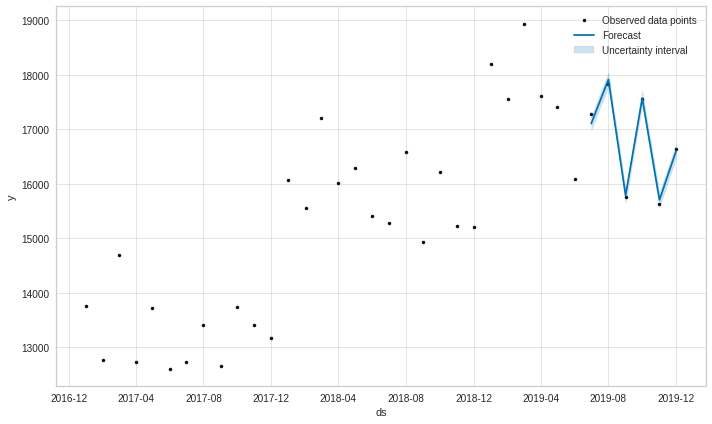

In [58]:
model.plot(forecast_ins, include_legend=True)
pyplot.show()

Create data for out of sample forecast

In [59]:
future_oos = list()
for i in range(1, 7):
 date = '2020-%02d' % i
 future_oos.append([date])
future_oos = pd.DataFrame(future_oos)
future_oos.columns = ['ds']
future_oos['ds']= pd.to_datetime(future_oos['ds'])

          ds          yhat    yhat_lower    yhat_upper
0 2020-01-01  19095.055449  18951.659139  19229.055078
1 2020-02-01  18698.001209  18567.388928  18836.397799
2 2020-03-01  20127.172968  19991.961856  20265.147816
3 2020-04-01  17832.451654  17689.946192  17976.530249
4 2020-05-01  19164.869409  19025.237352  19318.093145


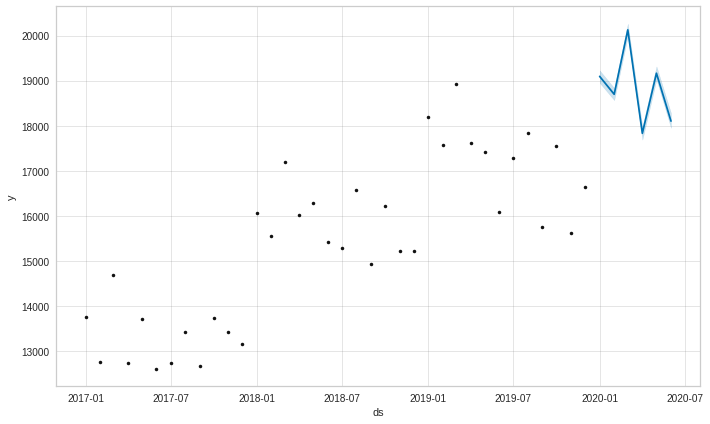

In [60]:
# use the model to make a forecast
forecast = model.predict(future_oos)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [61]:
# create test dataset, remove last 12 months
df = monthly_data_ts
train = df.drop(df.index[-12:])
print(train.tail())

                y         ds
datetime                    
2018-08-01  16579 2018-08-01
2018-09-01  14937 2018-09-01
2018-10-01  16222 2018-10-01
2018-11-01  15226 2018-11-01
2018-12-01  15217 2018-12-01


In [62]:
# calculate MAE between expected and predicted values for december
y_true = df['y'][-6:].values
y_pred = forecast_ins['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 68.892


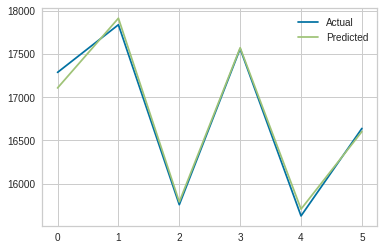

In [63]:
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

### With exogenous features

In this subsection we explore the improvement that exagenous variables from the dataset provide

In [72]:
daily_setup_ex = setup(data=daily_data_ts, target='pa_claim_made', fold=3, fh=7*4, enforce_exogenous=True, session_id=123)
monthly_setup_ex = setup(data=monthly_data_ts, target='pa_claim_made', fold=3, fh=6, enforce_exogenous=True, session_id=123)

,Description,Value
0,session_id,123
1,Target,pa_claim_made
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(1095, 5)"
5,Transformed data shape,"(1095, 5)"
6,Transformed train set shape,"(1067, 5)"
7,Transformed test set shape,"(28, 5)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Description,Value
0,session_id,123
1,Target,pa_claim_made
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(36, 5)"
5,Transformed data shape,"(36, 5)"
6,Transformed train set shape,"(30, 5)"
7,Transformed test set shape,"(6, 5)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [73]:
best_models_ex_daily = daily_setup_ex.compare_models(n_select=3)
best_models_ex_monthly = monthly_setup_ex.compare_models(n_select=3)
best_models_ex_daily
best_models_ex_monthly

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.1575,0.1093,5.8014,7.3920,0.0120,0.0119,0.9986,92.5467
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9565,0.8189,35.2173,55.2259,0.0898,0.0788,0.9097,1.9600
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.9662,0.8295,35.5809,55.9485,0.0873,0.0750,0.9064,2.3433
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.9935,0.8485,36.5881,57.2339,0.0901,0.0776,0.9032,4.5867
snaive,Seasonal Naive Forecaster,1.0090,0.8216,37.1429,55.4019,0.0821,0.0729,0.9102,0.4633
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0190,0.8782,37.5209,59.2200,0.0922,0.0808,0.8961,2.5767
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.1081,0.8976,40.7939,60.5293,0.1150,0.0975,0.8913,1.4433
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.1081,0.8976,40.7939,60.5293,0.1150,0.0975,0.8913,1.3500
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.1134,0.9126,40.9974,61.5538,0.1164,0.0984,0.8901,1.3333
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.1148,0.9006,41.0418,60.7288,0.1154,0.0978,0.8906,1.3200


Processing:   0%|          | 0/103 [00:00<?, ?it/s]

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.0571,0.0560,56.1882,66.3752,0.0035,0.0034,0.9892,1.8600
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8854,1.6747,1806.5676,1922.3892,0.1105,0.1173,-11.0941,0.1133
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.0176,1.7923,1919.4005,2040.4929,0.1162,0.1270,-14.2563,0.1400
naive,Naive Forecaster,2.0260,1.7849,1944.7778,2055.7901,0.1155,0.1255,-11.0933,0.0733
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,2.0293,1.9162,1961.0678,2232.9292,0.1210,0.1249,-13.6450,0.1467
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,2.0508,1.8540,1966.3848,2133.4209,0.1205,0.1283,-13.4138,0.2867
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,2.0525,1.8207,1960.3001,2081.4605,0.1203,0.1295,-14.4063,0.1133
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,2.0772,1.8484,1976.2529,2104.2516,0.1194,0.1315,-15.1170,0.1200
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,2.0889,1.8908,2001.5953,2174.2036,0.1229,0.1309,-14.5104,0.3300
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,2.1020,1.8792,2019.0485,2164.2799,0.1242,0.1315,-14.1494,0.1467


Processing:   0%|          | 0/99 [00:00<?, ?it/s]

[AutoARIMA(random_state=123, suppress_warnings=True),
 BaseCdsDtForecaster(regressor=LGBMRegressor(random_state=123), window_length=1),
 BaseCdsDtForecaster(regressor=GradientBoostingRegressor(random_state=123),
                     window_length=1)]

In [ ]:
best_tuned_models_ex_daily = [daily_setup_ex.tune_model(model) for model in best_models_ex_daily]
best_tuned_models_ex_monthly = [monthly_setup_ex.tune_model(model) for model in best_models_ex_monthly]
best_tuned_models_ex_daily
best_tuned_models_ex_monthly

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:11:53
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Results
Estimator,. . . . . . . . . . . . . . . . . .,Auto ARIMA


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 18.1min finished


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


KeyboardInterrupt: ignored

In [ ]:
exog_vars = ['is_weekday', 'is_holiday', 'is_workday', 'contraindication', 'tried_and_failed', 'correct_diagnosis', 'pa_approved'] 
data_exog = monthly_data_ts[exog_vars]

exog_exps = []
exog_models = []
for exog_var in exog_vars:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=monthly_data_ts[exog_var], fh=4, session_id=42
    )

    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    best = exog_exp.compare_models(
        sort="mase", include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]        
    )
    final_exog_model = exog_exp.finalize_model(best)

    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = exog_vars

,Description,Value
0,session_id,42
1,Target,is_weekday
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(36, 1)"
5,Transformed data shape,"(36, 1)"
6,Transformed train set shape,"(32, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9570,0.9530,1095.4279,1290.3434,0.0758,0.0746,-5.4558,0.1933
theta,Theta Forecaster,1.2160,1.1537,1396.3851,1563.5742,0.0947,0.0953,-11.0756,0.0600
ets,ETS,1.2627,1.1841,1451.6104,1606.3850,0.0985,0.0987,-10.9144,0.0767
exp_smooth,Exponential Smoothing,1.3336,1.2398,1532.3676,1681.1522,0.1040,0.1042,-12.1410,0.0467


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,is_holiday
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(36, 1)"
5,Transformed data shape,"(36, 1)"
6,Transformed train set shape,"(32, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,5.2368,2.8262,149.9019,150.7883,334654527402824256.0000,1.3675,-0.2864,0.0500
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,5.3258,2.8762,152.4815,153.5794,347744836968559040.0000,1.3664,-0.3399,0.0833


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,is_workday
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(36, 1)"
5,Transformed data shape,"(36, 1)"
6,Transformed train set shape,"(32, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0941,1.0570,1280.7246,1476.8240,0.0913,0.0892,-8.8631,0.1700
ets,ETS,1.4645,1.3498,1730.7474,1897.0383,0.1201,0.1211,-22.0552,0.1367
theta,Theta Forecaster,1.4720,1.3502,1741.4994,1900.2083,0.1207,0.1217,-21.9577,0.1467
exp_smooth,Exponential Smoothing,1.5999,1.4533,1896.8923,2048.9105,0.1312,0.1322,-25.0727,0.0867


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,contraindication
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(36, 1)"
5,Transformed data shape,"(36, 1)"
6,Transformed train set shape,"(32, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0287,0.9699,228.6324,261.8394,0.0689,0.0679,-3.7489,0.0733
theta,Theta Forecaster,1.3060,1.1858,292.2153,321.7162,0.0867,0.0868,-8.0200,0.0833
ets,ETS,1.3383,1.2025,299.7505,326.4867,0.0889,0.0888,-8.1666,0.1333
exp_smooth,Exponential Smoothing,1.3861,1.2403,310.7810,336.9157,0.0922,0.0918,-8.1855,0.0667


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,tried_and_failed
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(36, 1)"
5,Transformed data shape,"(36, 1)"
6,Transformed train set shape,"(32, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.1280,1.0589,592.8226,670.6382,0.0708,0.0703,-4.9437,0.0800
theta,Theta Forecaster,1.4294,1.2828,750.9536,811.2942,0.0880,0.0894,-7.3688,0.0633
ets,ETS,1.4812,1.3222,779.8374,837.5867,0.0914,0.0926,-7.7529,0.1100
exp_smooth,Exponential Smoothing,1.5290,1.3596,805.0062,861.2285,0.0944,0.0957,-8.2612,0.0667


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,correct_diagnosis
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(36, 1)"
5,Transformed data shape,"(36, 1)"
6,Transformed train set shape,"(32, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.2271,1.1090,982.2870,1081.9223,0.0732,0.0727,-5.8753,0.1633
theta,Theta Forecaster,1.5889,1.3842,1272.7062,1349.7987,0.0933,0.0945,-9.5151,0.0567
ets,ETS,1.6633,1.4408,1334.4157,1406.8491,0.0979,0.0989,-10.2094,0.0800
exp_smooth,Exponential Smoothing,1.7380,1.4986,1396.3349,1465.0082,0.1025,0.1033,-10.9788,0.0467


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,pa_approved
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(36, 1)"
5,Transformed data shape,"(36, 1)"
6,Transformed train set shape,"(32, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.1914,1.0684,892.1351,984.5007,0.0720,0.0717,-5.8010,0.1100
theta,Theta Forecaster,1.5056,1.3051,1127.9805,1200.7462,0.0896,0.0908,-9.0456,0.0900
ets,ETS,1.5668,1.3515,1175.9559,1245.0584,0.0934,0.0944,-9.5447,0.1267
exp_smooth,Exponential Smoothing,1.6356,1.4046,1228.5534,1294.7785,0.0977,0.0985,-10.2794,0.0767


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

             y_pred       lower       upper
2020-01  10926.4983  10850.5869  11002.4097
2020-02  11010.1547  10934.2433  11086.0661
2020-03  11093.8112  11017.8998  11169.7226
2020-04  11177.4675  11101.5561  11253.3789


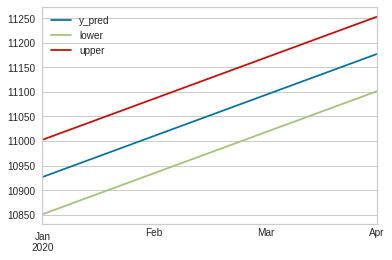

In [ ]:
final_model_ex_monthly = monthly_setup_ex.finalize_model(best_models_ex_monthly[0])
print(monthly_setup_ex.predict_model(final_model_ex_monthly, return_pred_int=True, X=future_exog))
monthly_setup_ex.predict_model(final_model_ex_monthly, return_pred_int=True, X=future_exog).plot()

# Deep Learning Models

In this section we investigate the performance of Dense, Convolutional, RNN(LSTM) models for our data.

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = daily_data_ts

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

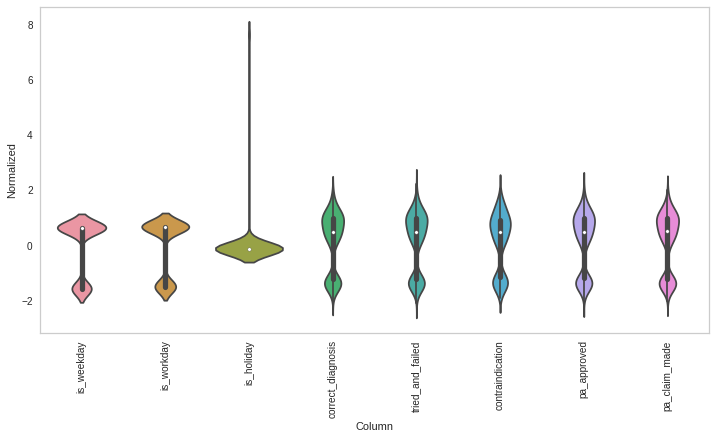

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['pa_claim_made'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['pa_claim_made']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['pa_claim_made'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['pa_claim_made']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 8)
Inputs shape: (3, 6, 8)
Labels shape: (3, 1, 1)


### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='pa_claim_made', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

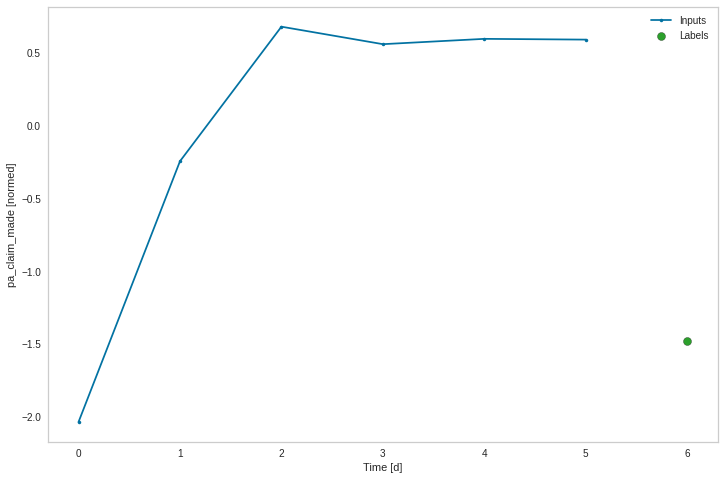

In [ ]:
w2.plot(max_subplots=1)

### 4. Create `tf.data.Dataset`s

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 8)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model one can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, we start by building models to predict the `pa_claim_made` value one hour into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['pa_claim_made'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pa_claim_made']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 8)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, we start with a model that just returns the current temperature as the prediction, predicting "No change".

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['pa_claim_made'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

7/7 [==============================] - 0s 4ms/step - loss: 1.6017 - mean_absolute_error: 0.8271


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['pa_claim_made'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['pa_claim_made']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


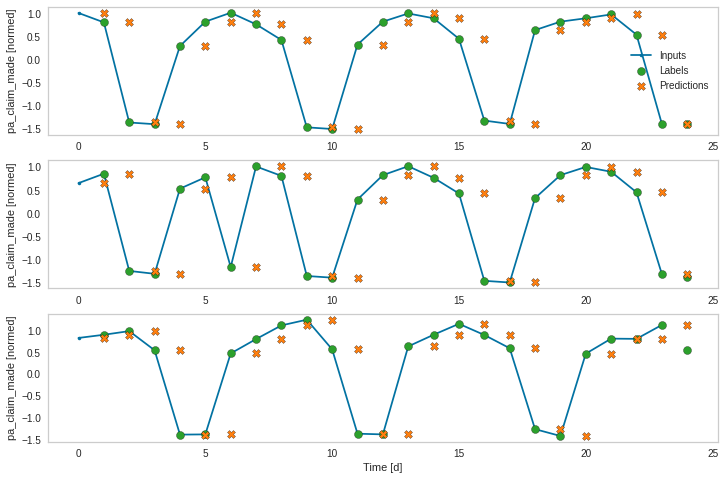

In [ ]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model one can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 8)
Output shape: (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
24/24 [==============================] - 1s 15ms/step - loss: 5.2098 - mean_absolute_error: 1.9659 - val_loss: 6.8339 - val_mean_absolute_error: 2.3634
Epoch 2/20
24/24 [==============================] - 0s 7ms/step - loss: 4.5866 - mean_absolute_error: 1.8499 - val_loss: 6.0115 - val_mean_absolute_error: 2.1987
Epoch 3/20
24/24 [==============================] - 0s 7ms/step - loss: 4.0374 - mean_absolute_error: 1.7407 - val_loss: 5.2815 - val_mean_absolute_error: 2.0479
Epoch 4/20
24/24 [==============================] - 0s 6ms/step - loss: 3.5537 - mean_absolute_error: 1.6375 - val_loss: 4.6567 - val_mean_absolute_error: 1.9152
Epoch 5/20
24/24 [==============================] - 0s 6ms/step - loss: 3.1346 - mean_absolute_error: 1.5411 - val_loss: 4.1149 - val_mean_absolute_error: 1.7966
Epoch 6/20
24/24 [==============================] - 0s 5ms/step - loss: 2.7748 - mean_absolute_error: 1.4506 - val_loss: 3.6372 - val_mean_absolute_error: 1.6912
Epoch 7/20
24/24 [=========

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


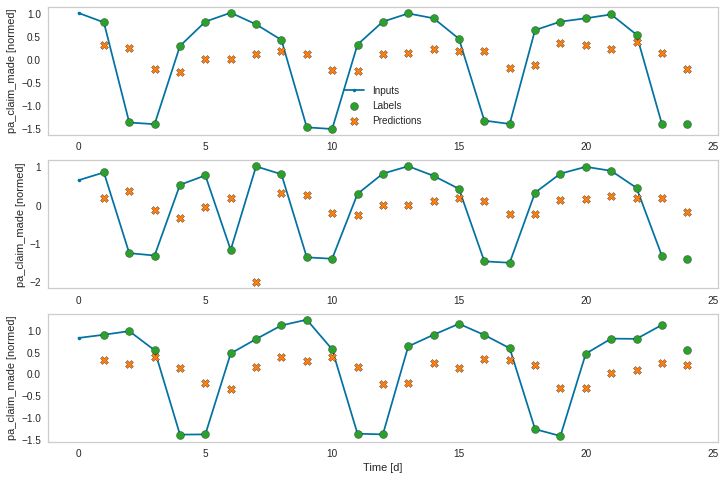

In [ ]:
wide_window.plot(linear)

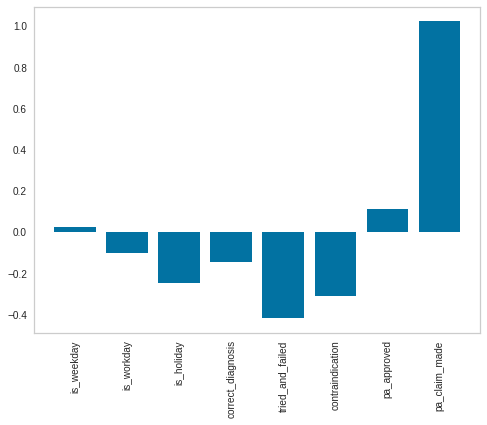

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
24/24 [==============================] - 1s 15ms/step - loss: 0.9478 - mean_absolute_error: 0.8260 - val_loss: 1.1560 - val_mean_absolute_error: 0.8707
Epoch 2/20
24/24 [==============================] - 0s 7ms/step - loss: 0.8059 - mean_absolute_error: 0.7356 - val_loss: 1.1572 - val_mean_absolute_error: 0.9826
Epoch 3/20
24/24 [==============================] - 0s 7ms/step - loss: 0.7930 - mean_absolute_error: 0.7425 - val_loss: 1.1401 - val_mean_absolute_error: 0.9376
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.7897 - mean_absolute_error: 0.7427 - val_loss: 1.1154 - val_mean_absolute_error: 0.9158
Epoch 5/20
24/24 [==============================] - 0s 8ms/step - loss: 0.7852 - mean_absolute_error: 0.7412 - val_loss: 1.1258 - val_mean_absolute_error: 0.9358
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 1.1377 - mean_absolute_error: 0.9537


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['pa_claim_made'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pa_claim_made']

Text(0.5, 1.0, 'Given 3 days of inputs, predict 1 day into the future.')

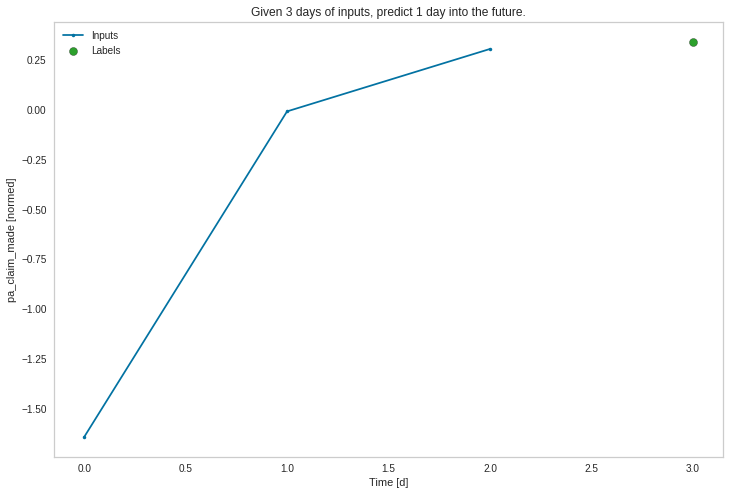

In [ ]:
conv_window.plot(max_subplots=1)
plt.title("Given 3 days of inputs, predict 1 day into the future.")

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 8)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

7/7 [==============================] - 0s 2ms/step - loss: 0.5280 - mean_absolute_error: 0.4892


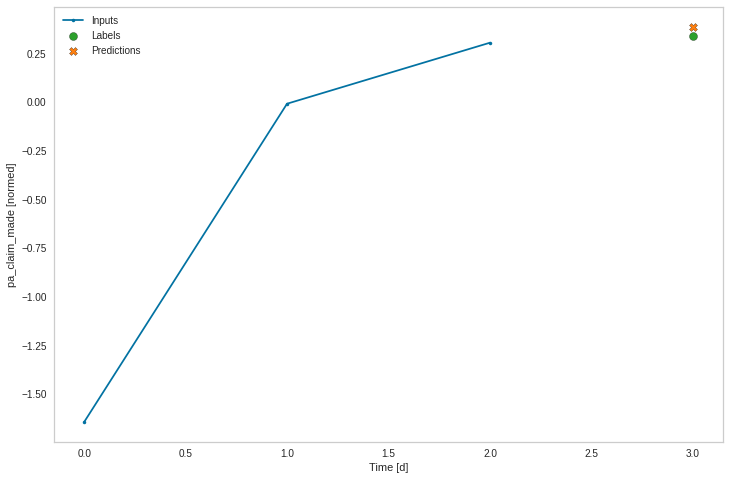

In [ ]:
conv_window.plot(multi_step_dense, max_subplots=1)

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 8)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

7/7 [==============================] - 0s 3ms/step - loss: 0.5201 - mean_absolute_error: 0.5160


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 8)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['pa_claim_made'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['pa_claim_made']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 8)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


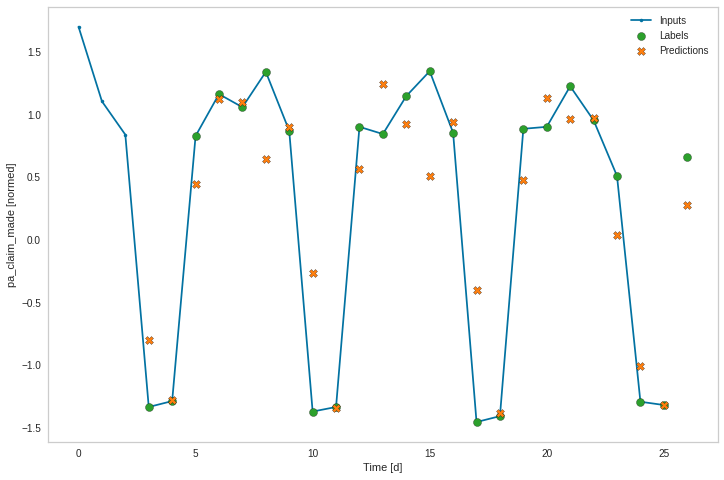

In [ ]:
wide_conv_window.plot(conv_model, max_subplots=1)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

A good reference is [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

We will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 8)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

7/7 [==============================] - 0s 6ms/step - loss: 0.2200 - mean_absolute_error: 0.2829


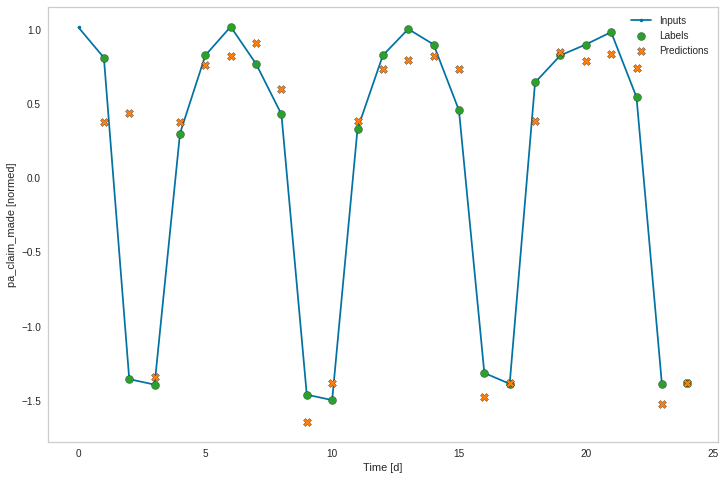

In [ ]:
wide_window.plot(lstm_model, max_subplots=1)

### Performance

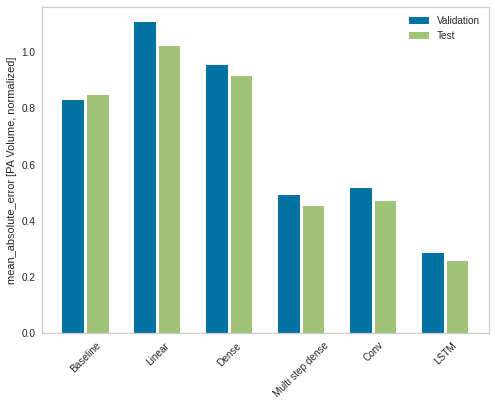

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [PA Volume, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.8455
Linear      : 1.0215
Dense       : 0.9134
Multi step dense: 0.4530
Conv        : 0.4711
LSTM        : 0.2570


### Multi-output models

The models so far all predicted a single output feature, `pa_claim_made`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 8)
Labels shape (batch, time, features): (32, 24, 8)


#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

7/7 [==============================] - 0s 2ms/step - loss: 1.5431 - mean_absolute_error: 0.7206


#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

7/7 [==============================] - 0s 2ms/step - loss: 1.0248 - mean_absolute_error: 0.7540


#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

7/7 [==============================] - 0s 5ms/step - loss: 0.2722 - mean_absolute_error: 0.2651

CPU times: user 15.4 s, sys: 1.18 s, total: 16.5 s
Wall time: 14.5 s


<a id="residual"></a>

#### Extra: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While we can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

7/7 [==============================] - 0s 5ms/step - loss: 0.3010 - mean_absolute_error: 0.3043

CPU times: user 15.7 s, sys: 1.32 s, total: 17 s
Wall time: 15.1 s


#### Performance

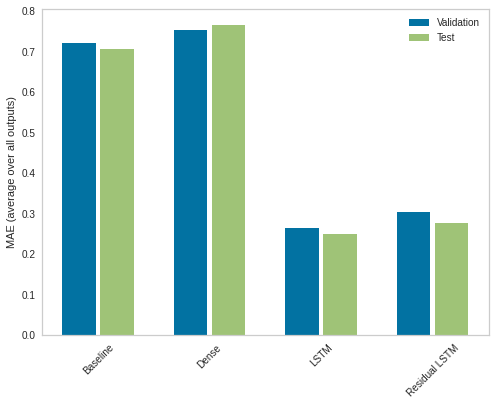

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.7059
Dense          : 0.7664
LSTM           : 0.2507
Residual LSTM  : 0.2780


## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

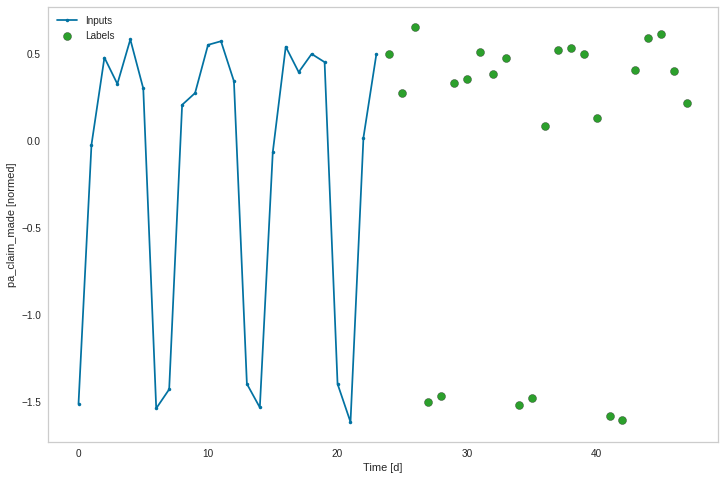

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(max_subplots=1)
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

6/6 [==============================] - 0s 2ms/step - loss: 2.3240 - mean_absolute_error: 1.0041


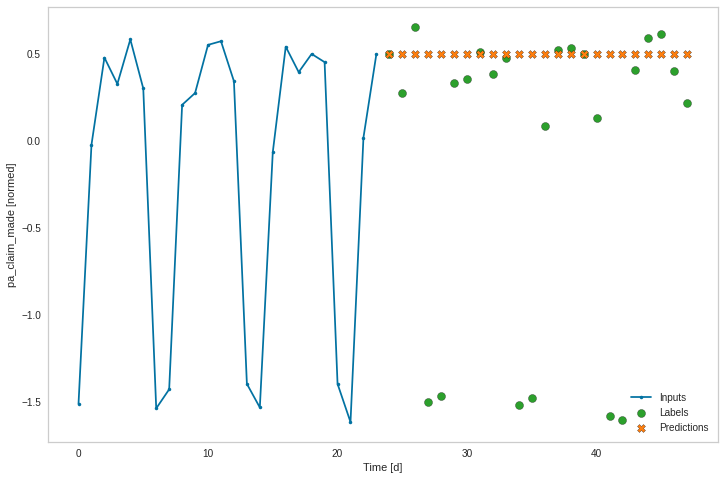

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline,max_subplots=1)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

6/6 [==============================] - 0s 3ms/step - loss: 3.2909 - mean_absolute_error: 1.3519


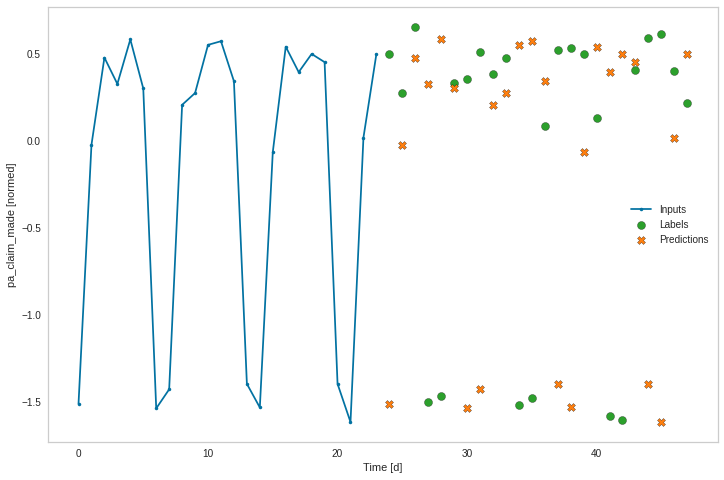

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline, max_subplots=1)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

6/6 [==============================] - 0s 3ms/step - loss: 0.9828 - mean_absolute_error: 0.7826


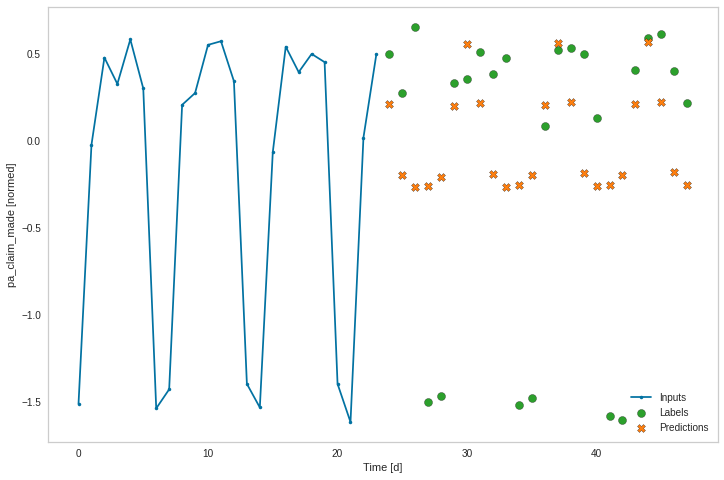

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model,max_subplots=1)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

6/6 [==============================] - 0s 5ms/step - loss: 0.9478 - mean_absolute_error: 0.7393


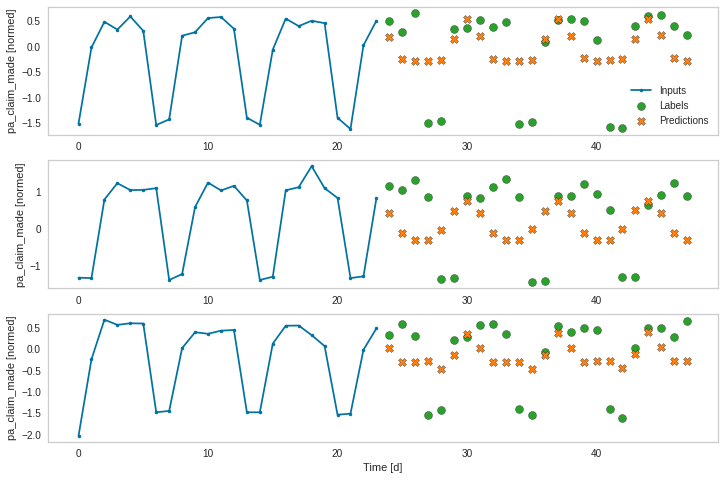

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

6/6 [==============================] - 0s 3ms/step - loss: 0.3499 - mean_absolute_error: 0.3336


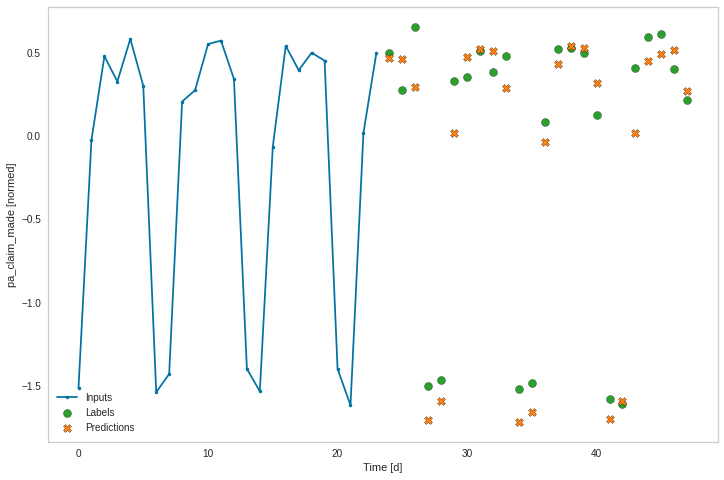

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model,max_subplots=1)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


6/6 [==============================] - 0s 5ms/step - loss: 0.2189 - mean_absolute_error: 0.2384


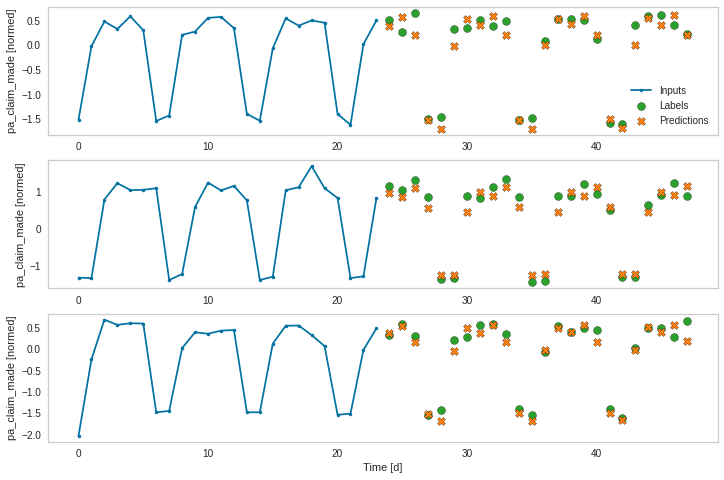

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

Here we build an autoregressive RNN model.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 8])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 8)


6/6 [==============================] - 0s 6ms/step - loss: 0.1923 - mean_absolute_error: 0.1978


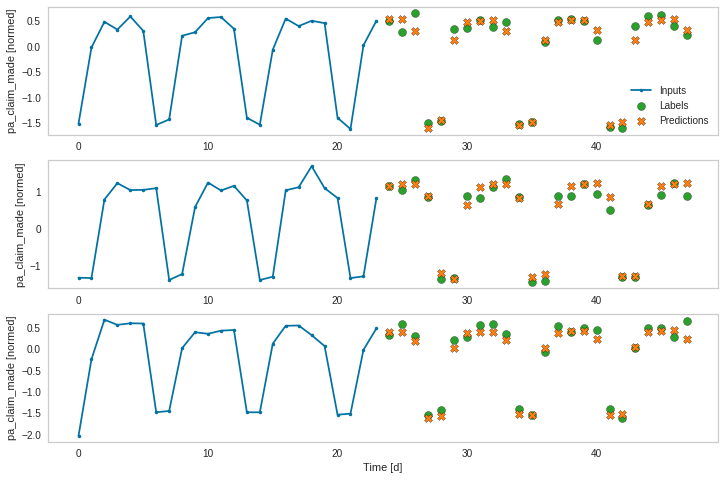

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

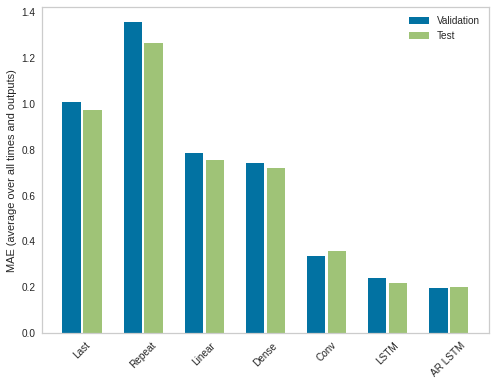

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.9686
Repeat  : 1.2611
Linear  : 0.7521
Dense   : 0.7194
Conv    : 0.3558
LSTM    : 0.2188
AR LSTM : 0.1991
